<a href="https://colab.research.google.com/github/legobitna/DeepLearning-basic/blob/main/7_3a_Building_a_neural_network_from_scratch_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building one hidden layer neural network of Planar data classification

It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation. Thanks to Tensorflow GradientTape, we don't need to worry about the derivative of our backward propagation.


## 0 - Helper Functions

Please run two these cells to define all helper functions! :)

In [2]:
#@title Test Cases Functions (provides some test cases to check if your functions implement correctly)
import numpy as np

def initialize_parameters_test_case():
    n_x, n_h, n_y = 2, 4, 1
    return n_x, n_h, n_y


def forward_propagation_test_case():
    X_assess = tf.Variable([[ 1.62434536, -1.07296862],
       [-0.61175641,  0.86540763],
       [-0.52817175, -2.3015387 ]])
    b1 = tf.Variable([[ 1.74481176, -0.7612069 ,  0.3190391 , -0.24937038]])
    b2 = tf.Variable([[-1.3]])

    parameters = {'W1': tf.Variable([[-0.00416758, -0.02136196, -0.01793436,  0.00502881],
       [-0.00056267,  0.01640271, -0.00841747, -0.01245288]]),
     'W2': tf.Variable([[-0.01057952],
       [-0.00909008],
       [ 0.00551454],
       [ 0.02292208]]),
     'b1': b1,
     'b2': b2}

    return X_assess, parameters


def compute_cost_test_case():
    Y_assess = tf.Variable([[ 1.], [0.], [0.]])
    parameters = {'W1': tf.Variable([[-0.00416758, -0.02136196, -0.01793436,  0.00502881],
       [-0.00056267,  0.01640271, -0.00841747, -0.01245288]]),
     'W2': tf.Variable([[-0.01057952],[-0.00909008],[ 0.00551454],[ 0.02292208]]),
     'b1': tf.Variable([[0., 0., 0., 0.]]),
     'b2': tf.Variable([[ 0.]])}

    a2 = (tf.Variable([[0.5002307 ],[0.49985831],[0.50023963]]))
    
    return a2, Y_assess, parameters


def update_parameters_test_case():
    parameters = {'W1': tf.Variable([[-0.00615039, -0.02311792, -0.0169217 ,  0.00935436],
       [ 0.0169021 ,  0.03137121, -0.01752545, -0.05018221]]),
 'W2': tf.Variable([[-0.0104319 ],
       [-0.04019007],
       [ 0.01607211],
       [ 0.04440255]]),
 'b1': tf.Variable([[-8.97523455e-07,  8.15562092e-06,  6.04810633e-07,
        -2.54560700e-06]]),
 'b2': tf.Variable([[  9.14954378e-05]])}

    grads = {'W1': tf.Variable([[ 0.00023322,  0.00082222, -0.00031831, -0.00092857],
       [-0.00205423, -0.00700776,  0.0028636 ,  0.00809933]]),
 'W2': tf.Variable([[-1.75740039e-05],
       [ 3.70231337e-03],
       [-1.25683095e-03],
       [-2.55715317e-03]]),
 'b1': tf.Variable([[ 1.05570087e-07, -3.81814487e-06, -1.90155145e-07,
         5.46467802e-07]]),
 'b2': tf.Variable([[ -1.08923140e-05]])}
    return parameters, grads

def nn_model_test_case():
    X_assess = tf.Variable([[ 1.62434536, -1.07296862],[-0.61175641,  0.86540763],[-0.52817175, -2.3015387 ]])
    Y_assess = tf.Variable([[ 1.],[0.],[ 1.]])
    return X_assess, Y_assess

def predict_test_case():
    X_assess = tf.Variable([[ 1.62434536, -1.07296862],
       [-0.61175641,  0.86540763],
       [-0.52817175, -2.3015387 ]])
    parameters = {'W1': tf.Variable([[-0.00615039, -0.02311792, -0.0169217 ,  0.00935436],
       [ 0.0169021 ,  0.03137121, -0.01752545, -0.05018221]]),
     'W2': tf.Variable([[-0.0104319 ],
       [-0.04019007],
       [ 0.01607211],
       [ 0.04440255]]),
     'b1': tf.Variable([[-8.97523455e-07,  8.15562092e-06,  6.04810633e-07,
        -2.54560700e-06]]),
     'b2': tf.Variable([[  9.14954378e-05]])}
    return parameters, X_assess

In [3]:
#@title Helper Function (plot decision boundary, load_planar_dataset, calculate accuracy)
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model

def plot_decision_boundary(model, X, y, type="numpy"):
    # Set min and max values and give it some padding
    try:
      X = X.numpy()
      y = y.numpy()
    except:
      pass
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    input = np.c_[xx.ravel(), yy.ravel()]
    # print(input)
    # print(type(input))
    if (type=="tensor"):
      try:
        input = tf.Variable(input, dtype="float32")
      except:
        pass
    Z = model(input)

    try:
      Z = Z.numpy()
    except:
      pass
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1)) # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = tf.constant(X, dtype='float32')
    Y = tf.constant(Y, dtype='float32')

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

def calculate_accuracy(prediction, Y):
  try:
    return float((np.dot(prediction.numpy().T,Y) + np.dot(1-prediction.numpy().T,1-Y))/float(tf.size(Y))*100)
  except:
    return float((np.dot(prediction.T,Y) + np.dot(1-prediction.T,1-Y))/float(tf.size(Y))*100)

## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- [tensorflow](https://www.tensorflow.org/api_docs/python/tf) is a Google library/framework for deep learning 

In [4]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

import tensorflow as tf

%matplotlib inline

tf.random.set_seed(42) # set a seed so that the results are consistent

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [5]:
X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

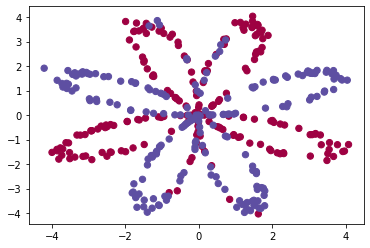

In [6]:
# Visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: You can just use .shape to get the shape for tensors

In [7]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[0]  # training set size
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (400, 2)
The shape of Y is: (400, 1)
I have m = 400 training examples!


**Expected Output**:

<table style="width:20%">  
  <tr>
    <td><b>shape of X</b></td>
    <td> (400, 2) </td> 
  </tr>
  <tr>
    <td><b>shape of Y</b></td>
    <td>(400, 1) </td> 
  </tr>
    <tr>
    <td><b>m</b></td>
    <td> 400 </td> 
  </tr>
</table>

## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [8]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


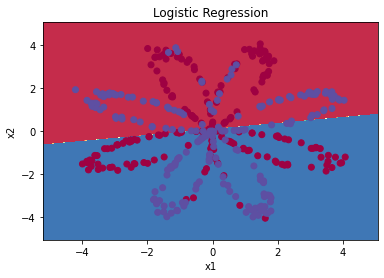

In [9]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y, "numpy")
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X)
print ('Accuracy of logistic regression: %d ' %  + calculate_accuracy(LR_predictions, Y) + '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td><b>Accuracy</b></td>
    <td> 47% </td> 
  </tr>
  
</table>


**Explanation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

Recall that $n^{[l]}$ is the number of units in layer $l$. Thus for example if the size of our input $X$ is $(400, 2)$ (with $m=400$ examples) then:

With $n^{[0]}$ = 2, $n^{[1]}$ = 4 and $n^{[2]}$ = 1

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> Shape of W </td> 
        <td> Shape of b  </td> 
        <td> -------------- Forward --------------</td>
        <td> ----- Activation -----</td>
        <td> Shape of Activation </td> 
    <tr>
    <tr>
        <td> Layer 1 </td> 
        <td> $(n^{[0]}, n^{[1]})$ </td> 
        <td> $(1, n^{[1]})$ </td> 
        <td> $Z^{[1]} = X.W^{[1]}   + b^{[1]}$ </td> 
        <td> $A^{[1]}$ = tanh($Z^{[1]}$) </td> 
        <td> $(400, n^{[1]})$ </td> 
    <tr>
    <tr>
        <td> Layer 2 </td> 
        <td> $(n^{[1]}, n^{[2]})$  </td> 
        <td> $(1, n^{[2]})$ </td> 
        <td>$Z^{[2]} = A^{[1]}.W^{[2]}  + b^{[2]}$ </td> 
        <td> $A^{[2]}$ = sigmoid($Z^{[2]}$) </td> 
        <td> $(400, n^{[2]})$ </td> 
    <tr>
</table>

**Here is our model**:
<img src="https://i.imgur.com/L2GnZ4Z.jpg" style="width:200px;">

**Mathematically**:

Here is the training flow of our model:
$$Z^{[1]} =  X . W^{[1]}  + b^{[1]}\tag{1. Forward Propagation Layer 1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2. Activation Layer 1}$$
$$Z^{[2]} = A^{[1]} . W^{[2]}  + b^{[2]}\tag{3. Forward Propagation Layer 2}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4. Activation Layer 2}$$
$$Y_{prediction} = \begin{cases} 1 & \mbox{if } A^{[2]} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5. Final Binary Classification Output}$$

Given the predictions on all the examples, you can also compute the cost $J$ (binary cross-entrophy) as follows: 
$$J = - \frac{1}{m}\sum\large\left(\small Y.\log\left(A^{[2]}\right) + (1-Y)\log\left(1- A^{[2]}\right)  \large  \right) \small \tag{6}$$

**Remember**: these are vectorization formulaes which calculate all m sample at the same time (faster due to matrix calculation parallelization) instead of looping for each sample i in m samples.

**Reminder**: The general methodology to build a Neural Network is to:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients (with the help of Tensorflow GradientTape)
        - Update parameters (one step of gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Exercise**: Define three variables:

    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [10]:
# Layer Sizes Function


def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[1]# size of input layer
    n_h = 4 # set this to be 4
    n_y = Y.shape[1] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [11]:
(n_x, n_h, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table style="width:20%">
  <tr>
    <td><b>n_x</b></td>
    <td> 2 </td> 
  </tr>
    <tr>
    <td><b>n_h</b></td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td><b>n_y</b></td>
    <td> 1 </td> 
  </tr>
</table>

### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `tf.random.uniform(shape=(a, b), minval=0, maxval=0.01)` to randomly initialize a matrix of shape (a,b). We can maxval to 0.01 to have which is a good practice for initilizing weights for a new model.
- You will initialize the bias vectors as zeros. 
    - Use: `tf.zeros(shape=(a, b))` to initialize a matrix of shape (a,b) with zeros.
- However, make sure you wrap all of above weights and bias with `tf.Variable(...)` so they will be Variables instead of Tensors (remember weights and bias need to be variable to be watched in GradientTape).

In [18]:
# Initialize Parameters Function

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    tf.random.set_seed(42) # we set up a seed so that your output matches ours although the initialization is random.
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = tf.Variable(tf.random.uniform(shape=(n_x,n_h),minval=0,maxval=0.01))
    b1 = tf.Variable(tf.zeros(shape=(1,n_h)))
    W2 = tf.Variable(tf.random.uniform(shape=(n_h,n_y),minval=0,maxval=0.01))
    b2 = tf.Variable(tf.zeros(shape=(1,n_y)))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_x, n_h))
    assert (b1.shape == (1, n_h))
    assert (W2.shape == (n_h, n_y))
    assert (b2.shape == (1, n_y))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [19]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"].numpy()))
print("b1 = " + str(parameters["b1"].numpy()))
print("W2 = " + str(parameters["W2"].numpy()))
print("b2 = " + str(parameters["b2"].numpy()))

W1 = [[0.00664562 0.00441007 0.00352883 0.00464483]
 [0.0003366  0.00684672 0.00740117 0.00872444]]
b1 = [[0. 0. 0. 0.]]
W2 = [[0.00687891]
 [0.00484479]
 [0.00930994]
 [0.00252187]]
b2 = [[0.]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td><b>W1</b></td>
    <td> [[0.00664562 0.00441007 0.00352883 0.00464483]
 [0.0003366  0.00684672 0.00740117 0.00872444]] </td> 
  </tr>
  <tr>
    <td><b>b1</b></td>
    <td> [[0. 0. 0. 0.]] </td> 
  </tr>
  <tr>
    <td><b>W2</b></td>
    <td> [[0.00687891]
 [0.00484479]
 [0.00930994]
 [0.00252187]]</td> 
  </tr>
  <tr>
    <td><b>b2</b></td>
    <td> [[ 0.]] </td> 
  </tr>
</table>



### 4.3 - The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `tf.math.sigmoid()`. It is part of the tensorflow library.
- You can use the function `tf.math.tanh()`. It is part of the tensorflow library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.

    2. Implement Forward Propagation. Compute     
$$Z^{[1]} -> A^{[1]} -> Z^{[2]} -> A^{[2]}$$ 
    (the vector of all your predictions on all the examples in the training set.

**Important:**
- Remember our array are Tensor array, not numpy array.
- Therefore, all the operations on those array and matrix have to use tf.math library instead of np library.
- For example:
  - tf.matmul (which is similar to np.dot)
  - tf.math.tanh (which is similar to np.tanh)
  - tf.math.sigmoid (which does not exist in numpy library)



In [24]:
# Forward Propagation Function

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = tf.matmul(X, W1) + b1
    A1 = tf.math.tanh(Z1)
    Z2 = tf.matmul(A1, W2) + b2
    A2 = tf.math.sigmoid(Z2)
    ### END CODE HERE ###

    assert(A2.shape == (X.shape[0], 1))
    return A2

In [25]:
X_assess, parameters = forward_propagation_test_case()
A2 = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(A2.numpy())

[[0.21292655]
 [0.21274674]
 [0.21295977]]


**Expected Output**:
<table style="width:50%">
  <tr>
    <td>[[0.21292655]
 [0.21274674]
 [0.21295977]]</td> 
  </tr>
</table>

**Now, time to calculate the cost function**

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m}\sum\large\left(\small Y.\log\left(A^{[2]}\right) + (1-Y)\log\left(1- A^{[2]}\right)  \large  \right) \small \tag{6}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. This is an example how a small part of the formulae could have been implemented
$- \sum Y\log(A^{[2]})$:
```python
logprobs = tf.multiply(tf.math.log(A2),Y)
cost = - tf.math.reduce_sum(logprobs)                
```

We can use `tf.squeeze` to remove redundant dimensions (in the case of single float, this will be reduced to a zero-dimension array).

Note we need to use tf operations instead of numpy operations since our matrix/array are tensor variables:
- tf.multiply = np.multiply
- tf.math.log = np.log
- tf.math.reduce_sum = np.sum
- tf.squeeze = np.squeeze

In [26]:
# Compute Cost Function

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (number of examples, 1)
    Y -- "true" labels vector of shape (number of examples, 1)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[0] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = tf.multiply(tf.math.log(A2),Y) + tf.multiply(1-Y,tf.math.log(1-A2))
    cost =  - tf.math.reduce_sum(logprobs)/m    
    ### END CODE HERE ###
    
    cost = tf.squeeze(cost)  # makes sure cost is the dimension we expect. # E.g., turns [[17]] into 17 

    return cost

In [27]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters).numpy()))

cost = 0.6930588


**Expected Output**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.693058761... </td> 
  </tr>
  
</table>

**Question**: Understand **backward propagation** 

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. However, thanks to Tensorflow GradientTape, we don't need to calculate derivates anymore, yayyy! But it's important to understand the intuition of backward progation.

- In backward propagation, we need to calculate these four terms of derivates:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$

Why? Because W1, b1, W2, b2 are the parameters of our models and we want to update them so that it will reduce/minimize the loss/cost function at every update gradient descent step. In order to do that, we need to calculate:
- The partial derivates of loss/cost function in respect to W1 (so we have $\frac{\partial \mathcal{J} }{ \partial W_1 }$)
- The partial derivates of loss/cost function in respect to b1 (so we have $\frac{\partial \mathcal{J} }{ \partial b_1 }$)
- The partial derivates of loss/cost function in respect to W2 (so we have $\frac{\partial \mathcal{J} }{ \partial W_2 }$)
- The partial derivates of loss/cost function in respect to b2 (so we have $\frac{\partial \mathcal{J} }{ \partial b_2 }$)

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$ 

- Note that $*$ denotes elementwise multiplication.
- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.-->

**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). 

<img src="https://i.imgur.com/R38Nmtv.gif" style="width:400;height:400;"> <img src="https://i.imgur.com/zsW2CxB.gif" style="width:400;height:400;">



In [32]:
# Update Parameters Function

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["W1"]
    db1 = grads["b1"]
    dW2 = grads["W2"]
    db2 = grads["b2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    # hint: remember to use .assign_sub instead of -= so tf.Variable stays Variable instead of Tensor
    W1.assign_sub(dW1*learning_rate)
    b1.assign_sub(db1*learning_rate)
    W2.assign_sub(dW2*learning_rate)
    b2.assign_sub(db2*learning_rate)
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [33]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"].numpy()))
print("b1 = " + str(parameters["b1"].numpy()))
print("W2 = " + str(parameters["W2"].numpy()))
print("b2 = " + str(parameters["b2"].numpy()))

W1 = [[-0.00643025 -0.02410458 -0.01653973  0.01046864]
 [ 0.01936718  0.03978052 -0.02096177 -0.05990141]]
b1 = [[-1.0242076e-06  1.2737395e-05  8.3299682e-07 -3.2013684e-06]]
W2 = [[-0.01041081]
 [-0.04463285]
 [ 0.01758031]
 [ 0.04747114]]
b2 = [[0.00010457]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td><b>W1</b></td>
    <td> [[-0.00643025 -0.02410458 -0.01653973  0.01046864]
 [ 0.01936718  0.03978052 -0.02096177 -0.05990141]]</td> 
  </tr>
  <tr>
    <td><b>b1</b></td>
    <td> [[-1.0242076e-06  1.2737395e-05  8.3299682e-07 -3.2013684e-06]]</td> 
  </tr>
  <tr>
    <td><b>W2</b></td>
    <td> [[-0.01041081]
 [-0.04463285]
 [ 0.01758031]
 [ 0.04747114]] </td> 
  </tr>
  <tr>
    <td><b>b2</b></td>
    <td> [[0.00010457]] </td> 
  </tr>
</table>  

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [34]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (number of examples, 2)
    Y -- labels of shape (number of examples, 1)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.random.set_seed(42)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

      with tf.GradientTape() as tape:
        ### START CODE HERE ### (≈ 4 lines of code)

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2".
        A2 = forward_propagation(X,parameters)

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2,Y,parameters)

        # Backpropagation. Inputs: "cost, parameters". Outputs: "grads".
        grads = tape.gradient(cost,parameters)

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads)

        ### END CODE HERE ###

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [35]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 =", parameters["W1"].numpy())
print("b1 =", parameters["b1"].numpy())
print("W2 =", parameters["W2"].numpy())
print("b2 =", parameters["b2"].numpy())

Cost after iteration 0: 0.693205
Cost after iteration 1000: 0.000240
Cost after iteration 2000: 0.000116
Cost after iteration 3000: 0.000076
Cost after iteration 4000: 0.000056
Cost after iteration 5000: 0.000045
Cost after iteration 6000: 0.000037
Cost after iteration 7000: 0.000031
Cost after iteration 8000: 0.000027
Cost after iteration 9000: 0.000024
W1 = [[ 0.8112657   0.419987    0.73739624 -0.7266394 ]
 [-1.4873153  -0.7993513  -1.3572621   1.3503177 ]]
b1 = [[-0.39242867 -0.13362968 -0.34529397  0.34325188]]
W2 = [[ 3.7983446]
 [ 1.1785626]
 [ 3.085757 ]
 [-3.0387194]]
b2 = [[0.21880262]]


**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        <b>cost after iteration 0</b>
    </td>
    <td> 
        0.693205
    </td>
</tr>
<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>
  <tr>
    <td><b>W1</b></td>
    <td> [[ 0.8112657   0.419987    0.73739624 -0.7266394 ]
 [-1.4873153  -0.7993513  -1.3572621   1.3503177 ]]</td> 
  </tr>
  <tr>
    <td><b>b1</b></td>
    <td> [[-0.39242867 -0.13362968 -0.34529397  0.34325188]] </td> 
  </tr>
  <tr>
    <td><b>W2</b></td>
    <td> [[ 3.7983446]
 [ 1.1785626]
 [ 3.085757 ]
 [-3.0387194]] </td> 
  </tr>
  <tr>
    <td><b>b2</b></td>
    <td> [[0.21880262]] </td> 
  </tr>
</table>  

### 4.5 Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = 

$$y_{prediction} = \begin{cases} 1 & \text{if}\ activation > 0.5 \\0 & \text{otherwise} \end{cases}$$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [36]:
# prediction function

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, n_x)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2 = forward_propagation(X,parameters)
    predictions = A2 > 0.5
    ### END CODE HERE ###
    
    return predictions

In [37]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(tf.reduce_mean(tf.cast(predictions, tf.float32)).numpy()))

predictions mean = 0.6666667


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td><b>predictions mean</b></td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

In [38]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.693170
Cost after iteration 1000: 0.282306
Cost after iteration 2000: 0.269353
Cost after iteration 3000: 0.262207
Cost after iteration 4000: 0.257568
Cost after iteration 5000: 0.254375
Cost after iteration 6000: 0.252070
Cost after iteration 7000: 0.250340
Cost after iteration 8000: 0.248999
Cost after iteration 9000: 0.247933


**Expected Output**:

<table style="width:40%">
  <tr>
    <td><b>Cost after iteration 0</b></td>
    <td> 0.693170 </td> 
  </tr>
  <tr>
    <td><b>Cost after iteration 9000</b></td>
    <td> 0.247933 </td> 
  </tr>
  
</table>


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

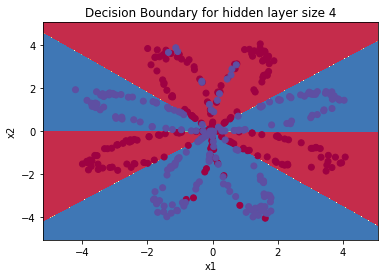

In [39]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x), X, Y, "tensor")
plt.title("Decision Boundary for hidden layer size " + str(4))

In [40]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy of our neural network: %d ' % calculate_accuracy(predictions, Y) +'% ')

Accuracy of our neural network: 91 % 


**Expected Output**: 

<table style="width:15%">
  <tr>
    <td><b>Accuracy</b></td>
    <td> 91% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional exercise) ###

The above model has only 4 neuron for the hidden layer. What if we change the number of neurons of that layer, how will it affect the accuracy?

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes (1, 2, 3, 4, 5, 20, 50).

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.75 %
Accuracy for 5 hidden units: 91.5 %
Accuracy for 20 hidden units: 50.0 %
Accuracy for 50 hidden units: 90.75 %


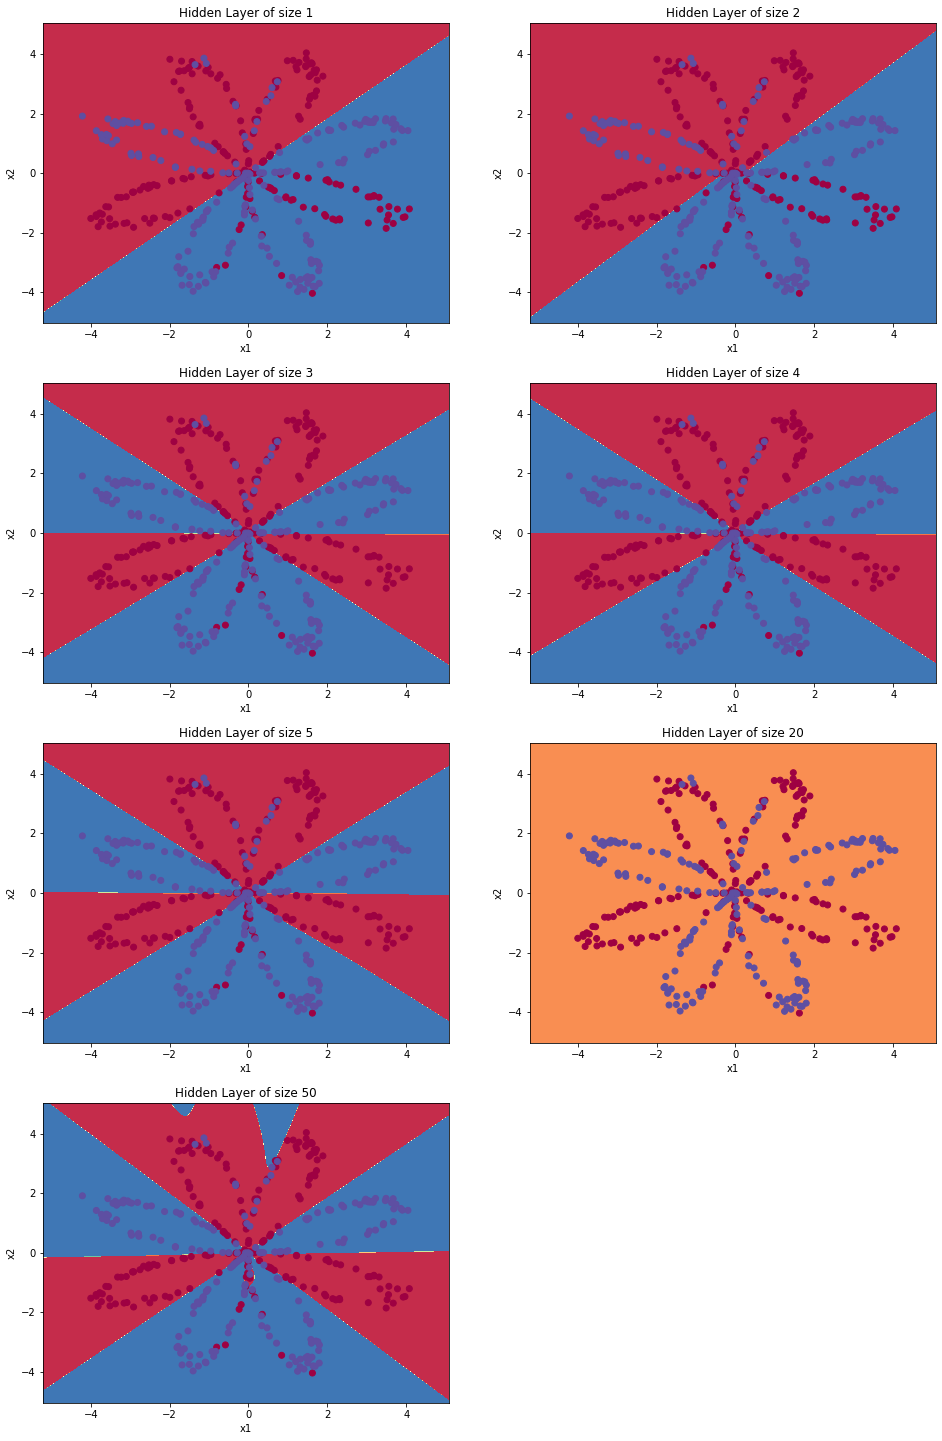

In [41]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x), X, Y,"tensor")
    predictions = predict(parameters, X)
    accuracy = calculate_accuracy(predictions, Y)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticeable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

**Optional questions**:

Some optional questions that you can explore if you wish: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation? (which section of the training code if you want to change activation functions?)
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

**You've learnt to:**
- Build a complete neural network with a hidden layer
- Make a good use of a non-linear unit
- Implemented forward propagation and backpropagation, and trained a neural network
- See the impact of varying the hidden layer size, including overfitting.

Nice work! But here are more datasets for you to play around with, yayyyy!

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

The shape of X is: (200, 2)
The shape of Y is: (200, 1)
I have m = 200 training examples!


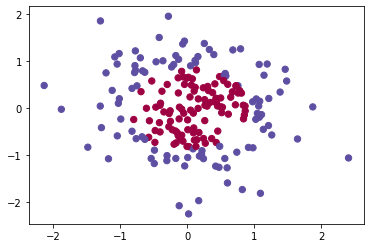

In [44]:
# Extra Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset among those four above)
dataset = "gaussian_quantiles"
### END CODE HERE ###

X, Y = datasets[dataset]

# make blobs binary
if dataset == "gaussian_quantiles":
    Y = Y%2

# convert the dataset to tensors
X = tf.constant(X, dtype="float32")
Y = tf.constant(Y, dtype="float32")

# make sure Y got two dimensions
Y = tf.reshape(Y, [-1, 1])

# Visualize the data
plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.Spectral);

# Get the shape of the dataset
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[0]  # training set size

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

Now it's your turn to play around with these 4 different datasets to train your own model!

Accuracy for 1 hidden units: 67.0 %
Accuracy for 2 hidden units: 82.0 %
Accuracy for 3 hidden units: 50.0 %
Accuracy for 4 hidden units: 50.0 %
Accuracy for 5 hidden units: 50.0 %
Accuracy for 20 hidden units: 50.0 %
Accuracy for 50 hidden units: 50.0 %


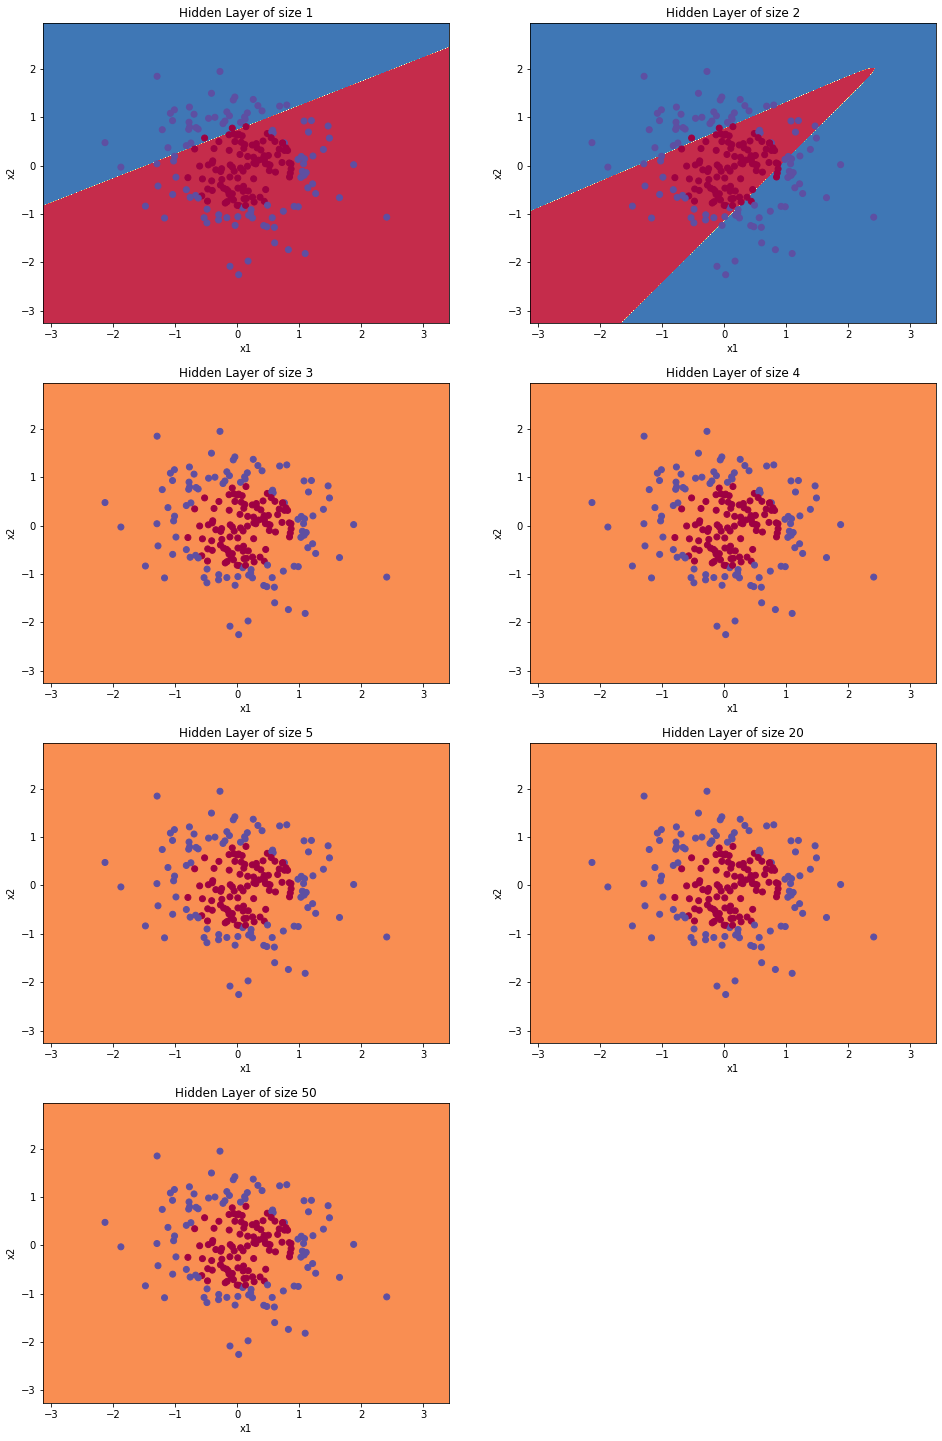

In [45]:
# Build a model with a n_h-dimensional hidden 
# YOUR CODE HERE

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x), X, Y,"tensor")
    predictions = predict(parameters, X)
    accuracy = calculate_accuracy(predictions, Y)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

In [ ]:
# Plot the decision boundary
# YOUR CODE HERE


Congrats on finishing this Programming Assignment!

Reference:
- http://cs231n.github.io/neural-networks-case-study/

## Bonus with Tensorflow/Keras 

So far, this seems to be easy enough with tf.GradientTape API for automatic differentiation but it seems to be a lot of work when we build a deeper model and more complicated ones. Is it how we actually build deep learning model from now on?

Thank god NO! With the framework like Keras which is fully supported in Tensorflow, the whole process of building above 2-layer model could look like this!


In [ ]:
tf.random.set_seed(42)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

model = Sequential()
model.add(Dense(4, activation='tanh', input_shape=(2,)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=SGD(learning_rate=1.2),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

That's it. The above model is pretty much the same with the model we have building for 2 hours or more. 

Time to train/fit our data. Note that, we use X.T and Y.T because the first dimesion has to match (the number of samples m) which is similar to any sklearn model.

In [ ]:
# we want it to match the number of iterations of our models (10,000 iterations) to be fair
# so with batch_size=1 and m=400, to have 10,000 updates for keras, we need to do 10,000/400 epoches 
number_of_epoches=int(10000/400) 

model.fit(X, Y, batch_size=1, epochs=number_of_epoches, verbose=1)

Here is how you get some predictions from our model (which is very similar to sklearn, yayyy!)

In [ ]:
predictions=model.predict(X)
predictions[:10]

You can even get metrics like this like accuracy.

In [ ]:
model.evaluate(X,Y)

Time to get parameters from the model and plot the decision boundary

In [ ]:
weights = model.get_weights()

We got 4 because of W1, b1, W2, b2.

In [ ]:
len(weights)

Put them back into a dictionary so we can plug it in plot decision boundary function.

In [ ]:
parameters={}
parameters["W1"] = tf.Variable(weights[0])
parameters["b1"] = tf.Variable(weights[1])
parameters["W2"] = tf.Variable(weights[2])
parameters["b2"] = tf.Variable(weights[3])

Here is how it looks like, much pretty the same with what we got before for the shape!

In [ ]:
parameters

Time to plot the decision boundary and compare it with our model from scratch! 

In [ ]:
# Plot the decision boundary for our tensorflow keras model

plot_decision_boundary(lambda x: predict(parameters, x), X, Y, "tensor")
plt.title("Decision Boundary for hidden layer size " + str(4))

It looks pretty much the same so it means that our implementation is pretty on point! Rememeber there are no way to these two models to have the same accuracy/decision boundary because random seed number, weight intilization, batch size, ... are different as Keras Dense Layers got some nice default settings.

**Congrats for finishing up one of the most difficult and interesting notebook of deep learning!**

![](https://media3.giphy.com/media/3oEhmWpgHJj2GuvBnO/giphy.gif)

### Your bonus task:
In our keras model, can you change the number of neurons to be 50 in that hidden layer and plot the decision boundary to see if it is overfitting?

In [ ]:
# YOUR CODE HERE
